In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevents column wrapping in Jupyter Notebook
pd.set_option('display.width', 1000)  # Adjusts the display width to fit more columns

In [254]:
def load_data(file_path, label):
    df = pd.read_csv(file_path)
    df['label'] = label
    df['requests_rate'] = 1
    return df

# Example usage
benign_data = load_data('./BCCC-CIC-IDS-2017/friday_benign.csv', 'benign')
ddos_data = load_data('./BCCC-CIC-IDS-2017/ddos_loit.csv', 'ddos')

# Combine datasets
benign_data['datetime'] = pd.to_datetime(benign_data['timestamp'])
benign_data.set_index('datetime', inplace=True)
benign_data.sort_index(inplace=True)

ddos_data['datetime'] = pd.to_datetime(ddos_data['timestamp'])
ddos_data.set_index('datetime', inplace=True)
ddos_data.sort_index(inplace=True)

In [255]:
bening_subnet = benign_data[(benign_data['dst_ip'].str.startswith('192.168')) & (benign_data['protocol'] == 'TCP')]
ddos_subnet = ddos_data[ddos_data['dst_ip'].str.startswith('192.168')]

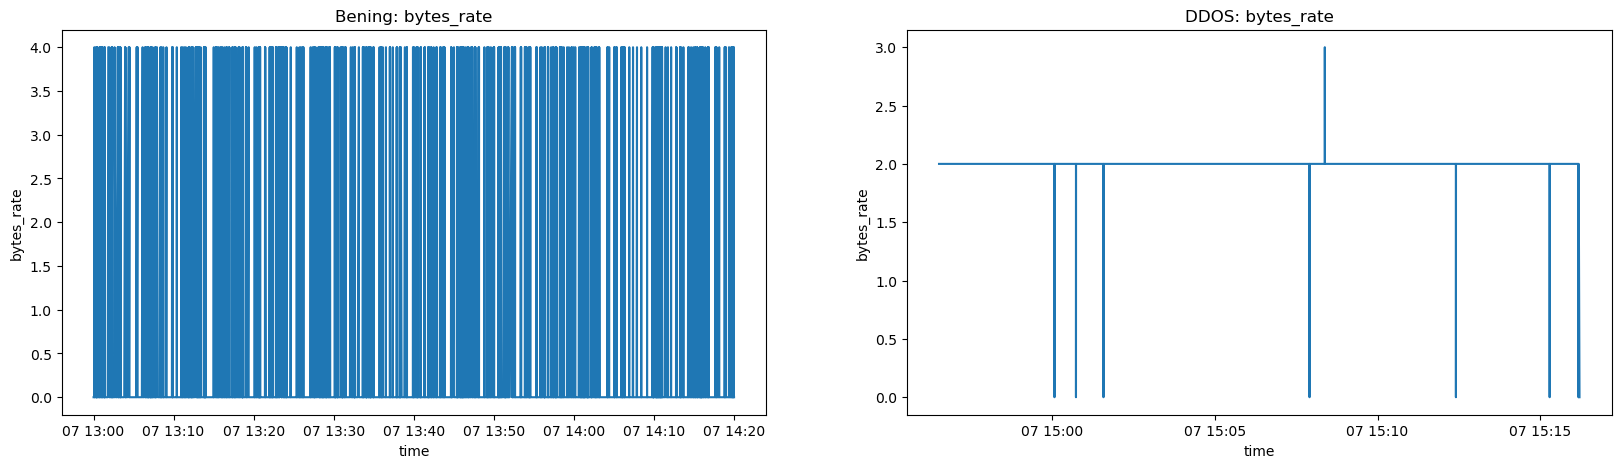

In [256]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

bening_window = bening_subnet.between_time('13:00', '14:20')

ax1.plot(bening_window.index, bening_window['syn_flag_counts'])
ax1.set_title('Bening: bytes_rate')
ax1.set_ylabel('bytes_rate')
ax1.set_xlabel('time')

ax2.plot(ddos_subnet.index, ddos_subnet['syn_flag_counts'])
ax2.set_title('DDOS: bytes_rate')
ax2.set_ylabel('bytes_rate')
ax2.set_xlabel('time')

plt.show()

In [261]:
features = ['syn_flag_counts', 'rst_flag_counts', 'ack_flag_counts', 'duration', 'packets_count', 'fwd_packets_count', 'bwd_packets_count', 'unique_dst_ports', 'unique_src_ips', 'bytes_rate', 'packets_rate', 'requests_rate']

In [262]:
aggregations = {
    'syn_flag_counts': 'sum',         # Total SYN packets in 1s
    'rst_flag_counts': 'sum',         # Total RST packets in 1s
    'ack_flag_counts': 'sum',         # Total ACK packets in 1s
    'duration': 'mean',               # Avg duration of connections
    'packets_count': 'sum',           # Total packets per second
    'fwd_packets_count': 'sum',       # Total forward packets
    'bwd_packets_count': 'sum',       # Total backward packets
    'dst_port': 'nunique',            # Unique destination ports per second (Port Scan)
    'src_ip': 'nunique',              # Unique source IPs per second
    'bytes_rate': 'mean',             # Avg bytes per second
    'packets_rate': 'mean',           # Avg packets per second,
    'requests_rate': 'count'          # Number of requests per aggregation period (1s by default)
}

bening_subnet_agg = bening_subnet.resample('1s').agg(aggregations).rename(columns={
    'dst_port': 'unique_dst_ports',
    'src_ip': 'unique_src_ips'
})

ddos_subnet_agg = ddos_subnet.resample('1s').agg(aggregations).rename(columns={
    'dst_port': 'unique_dst_ports',
    'src_ip': 'unique_src_ips'
})

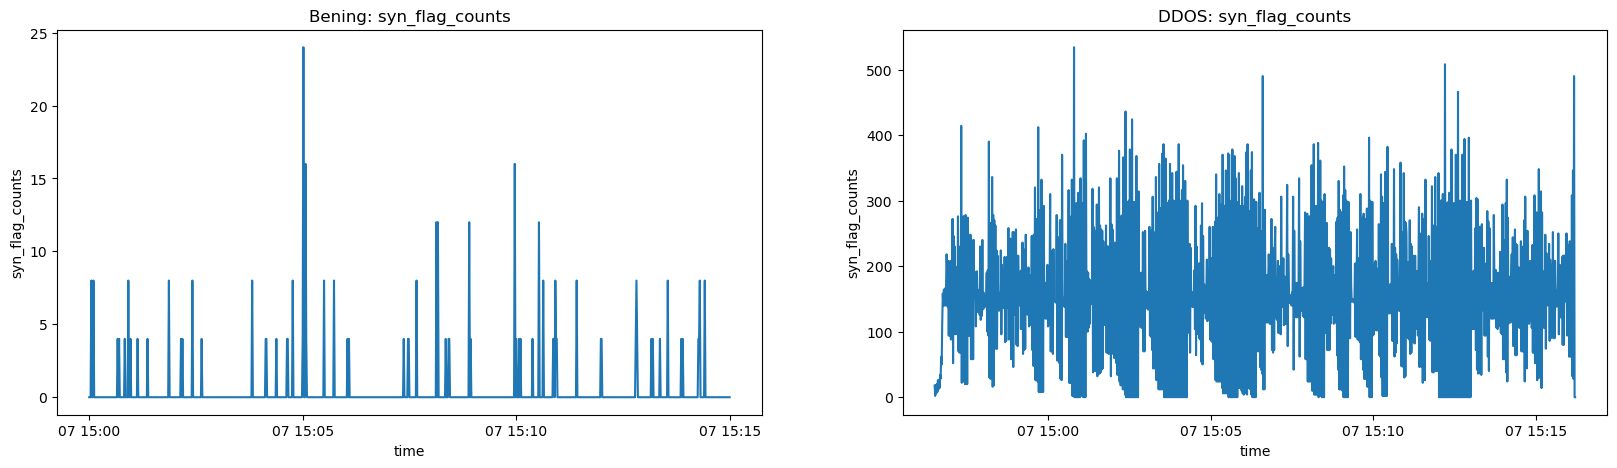

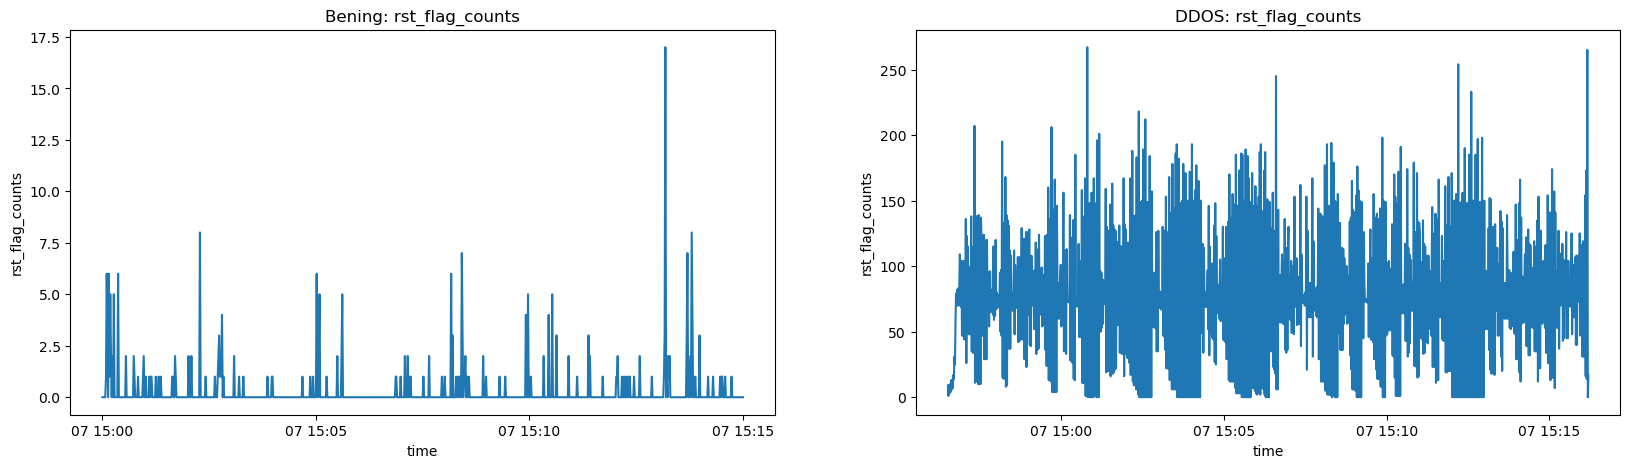

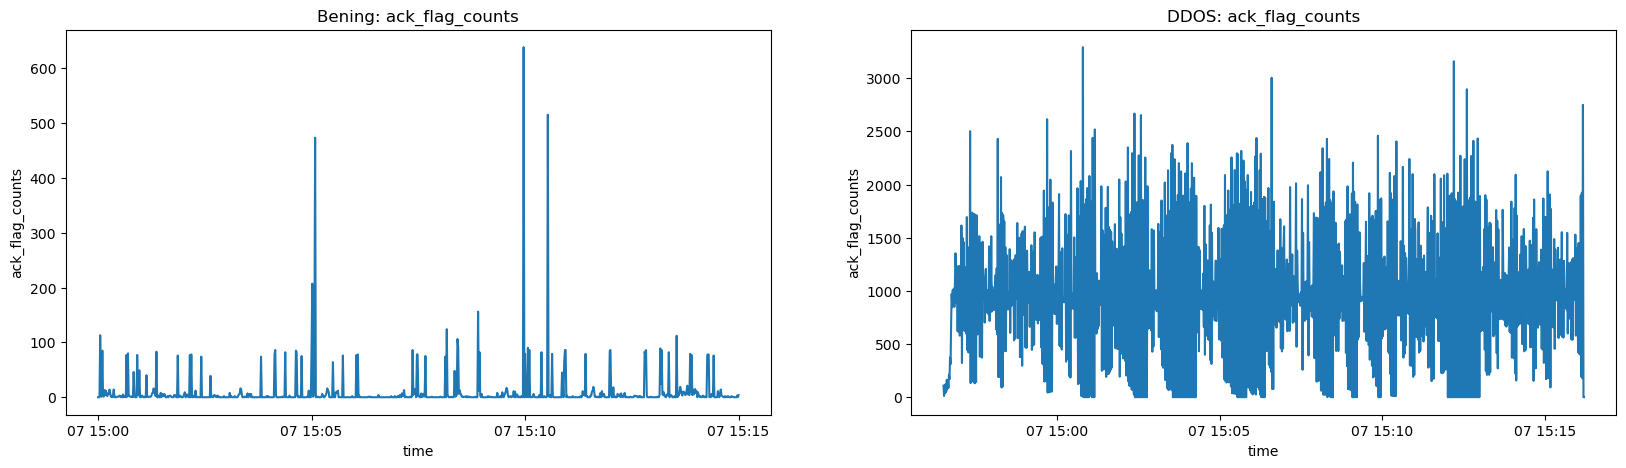

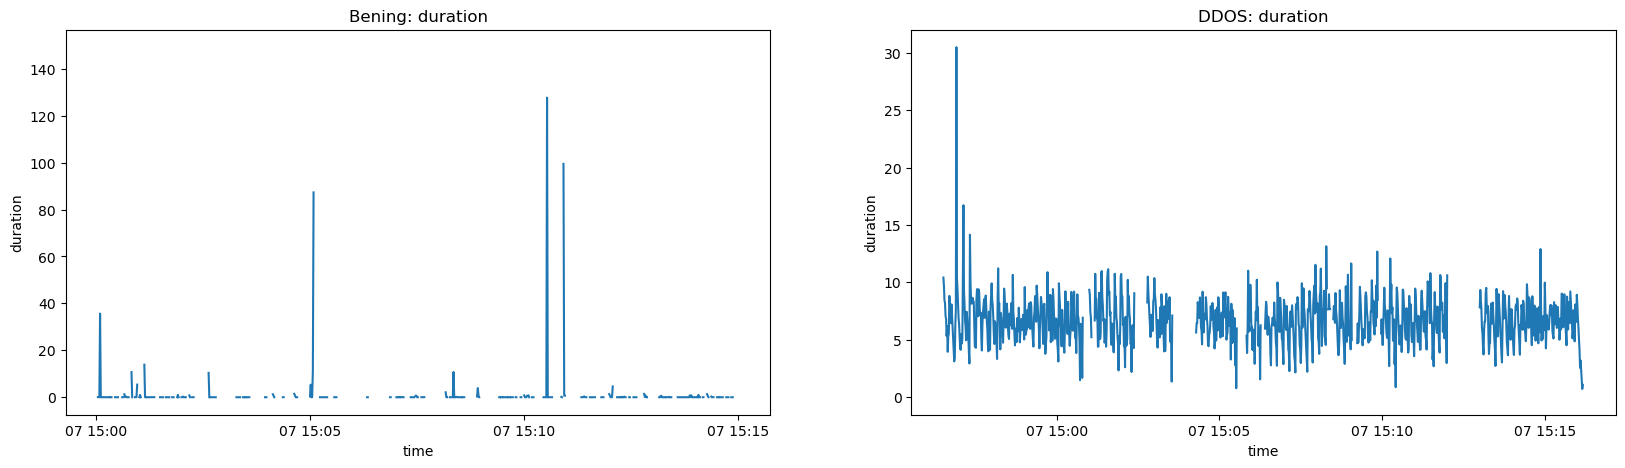

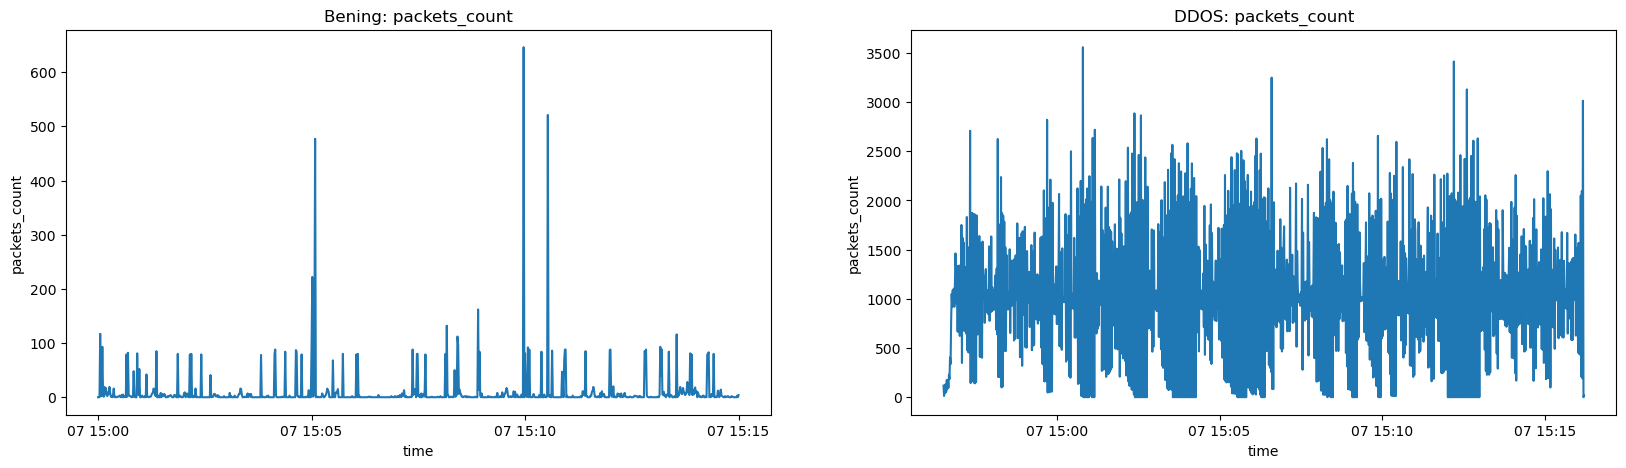

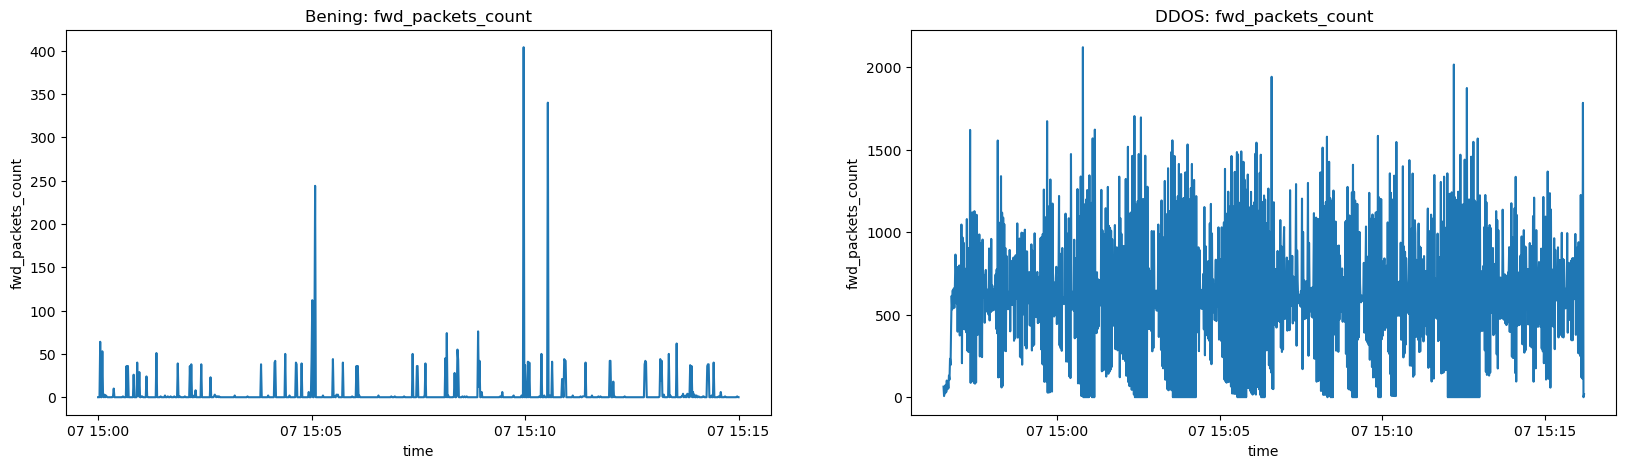

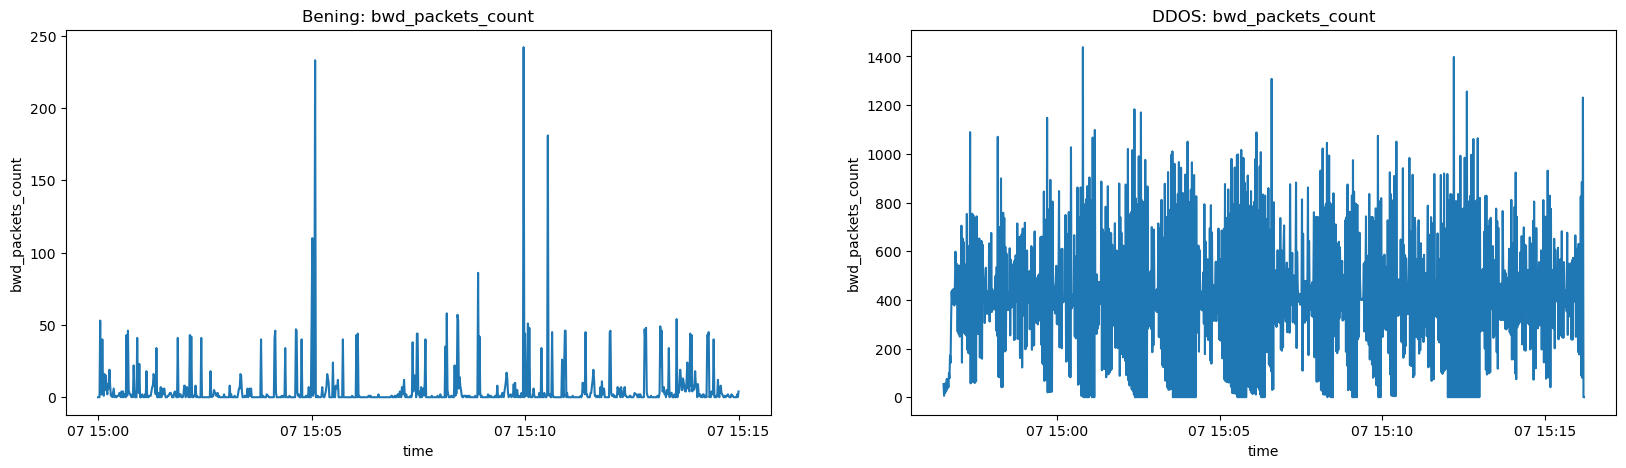

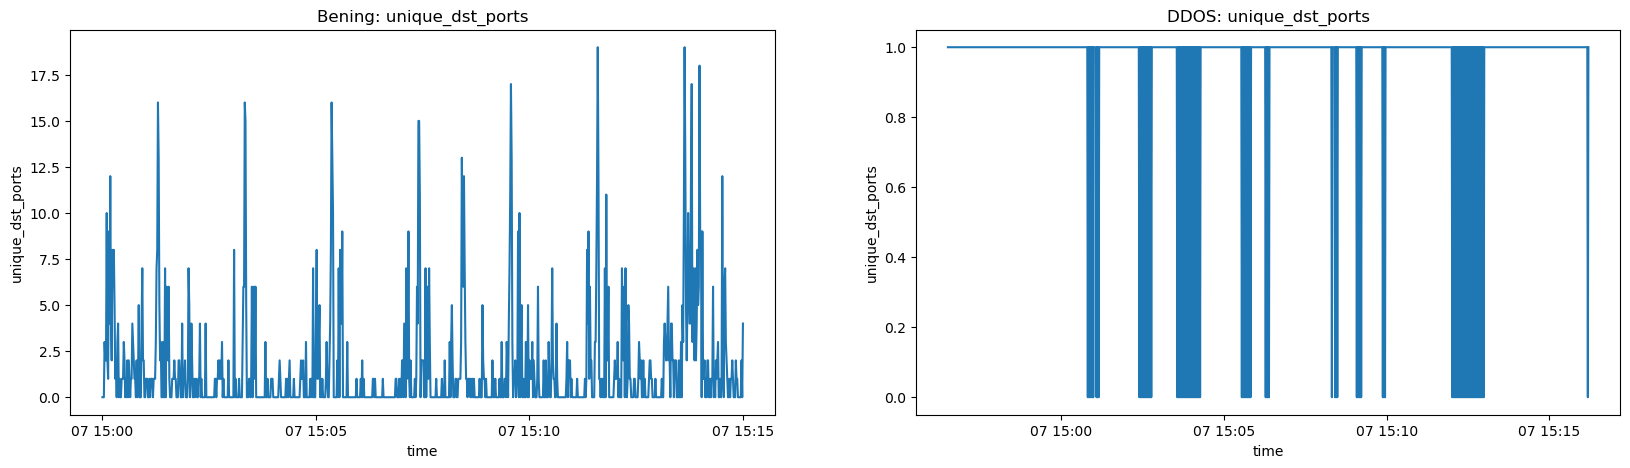

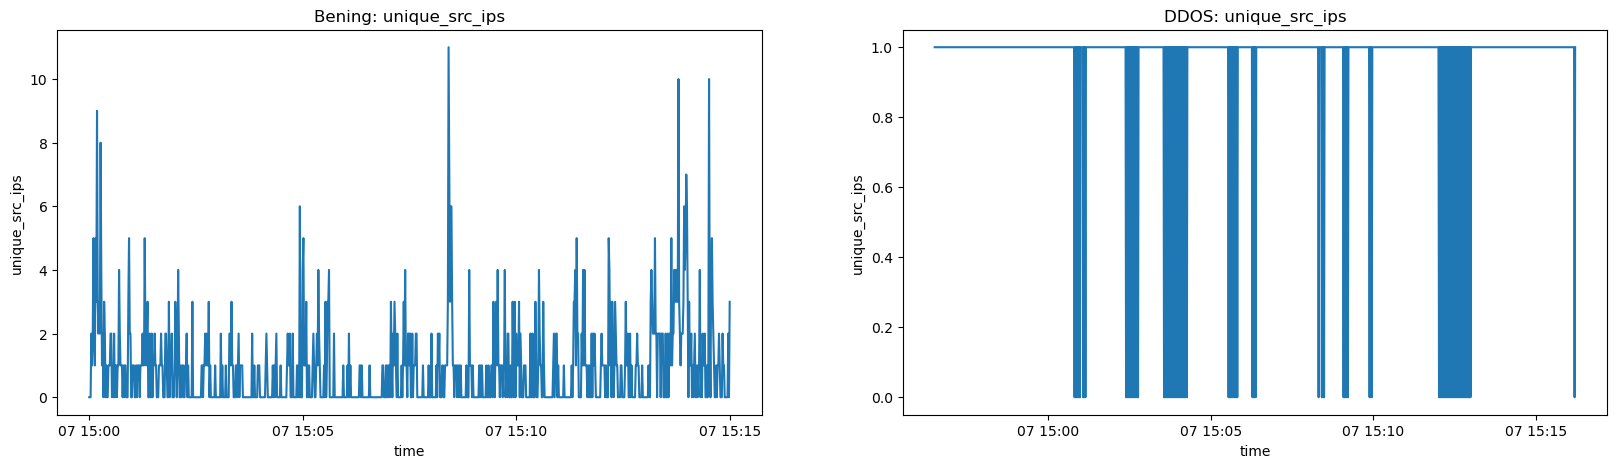

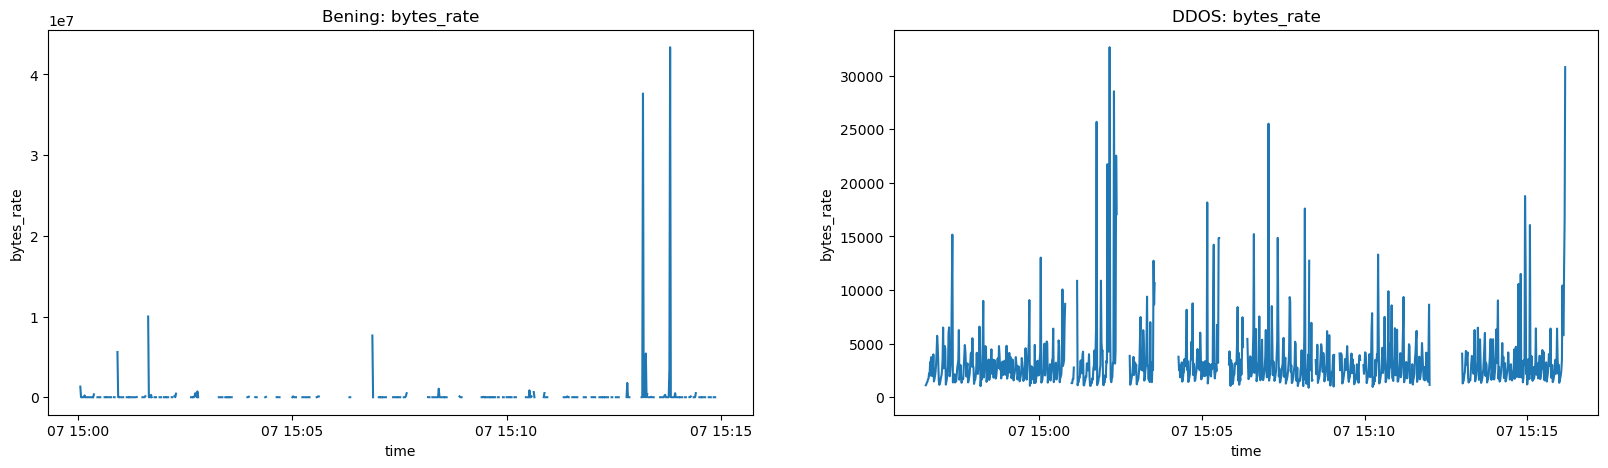

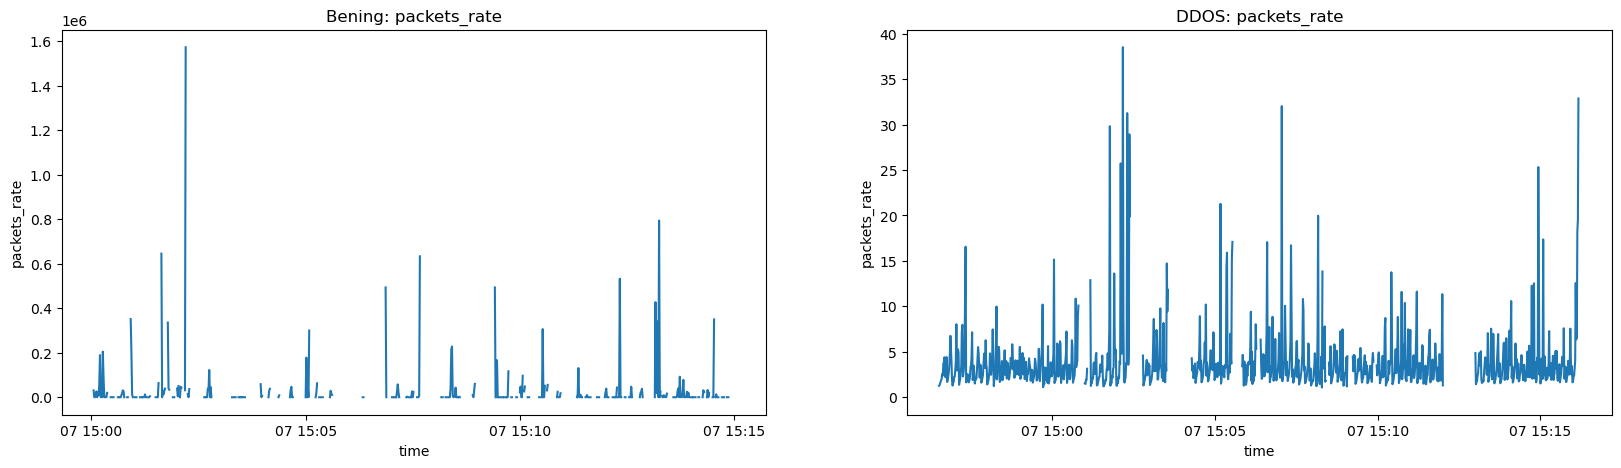

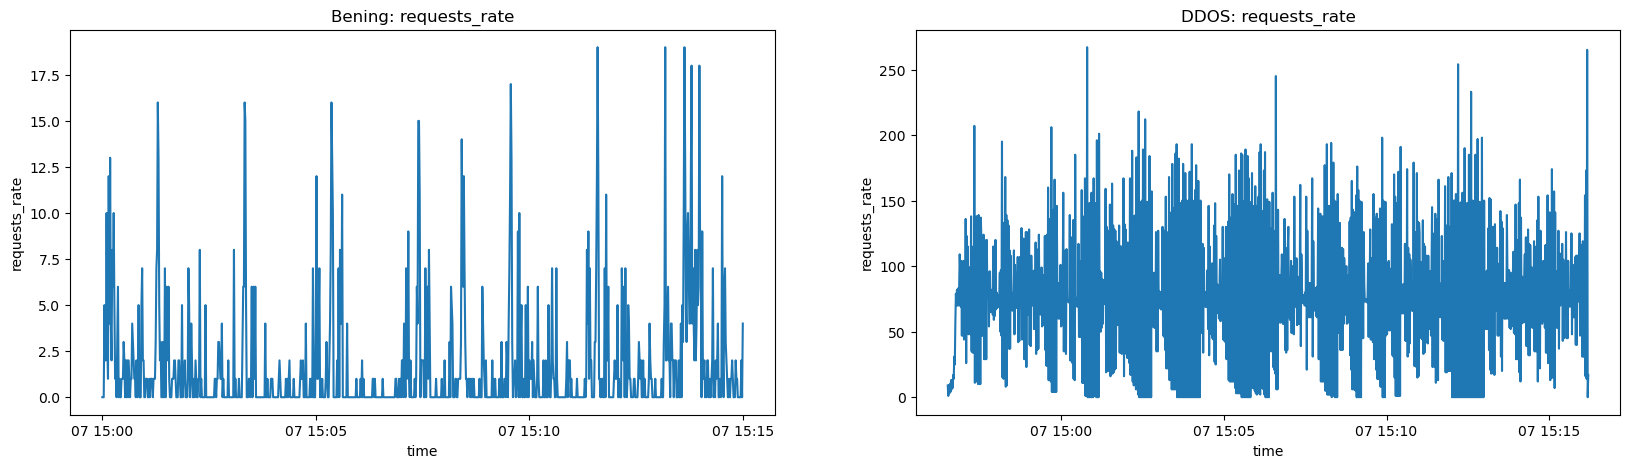

In [263]:

for feature in features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    bening_window = bening_subnet_agg.between_time('15:00', '15:15')

    ax1.plot(bening_window.index, bening_window[feature])
    ax1.set_title(f'Bening: {feature}')
    ax1.set_ylabel(feature)
    ax1.set_xlabel('time')

    ax2.plot(ddos_subnet_agg.index, ddos_subnet_agg[feature])
    ax2.set_title(f'DDOS: {feature}')
    ax2.set_ylabel(feature)
    ax2.set_xlabel('time')

plt.show()

Now let's try to apply Isolation forrest on these features to detect DDOS.

First, we need to combine both bening and malign data for friday

In [264]:
friday_data = pd.concat([ddos_subnet, bening_subnet], ignore_index=True)
friday_data['datetime'] = pd.to_datetime(friday_data['timestamp'])
friday_data.set_index('datetime', inplace=True)
friday_data.sort_index(inplace=True)

aggregations['label'] = lambda x: 0 if x.eq('benign').all() else 1
friday_data_agg = friday_data.resample('1s').agg(aggregations).rename(columns={
    'dst_port': 'unique_dst_ports',
    'src_ip': 'unique_src_ips'
})

print(f"There are {friday_data_agg['label'].nunique()} unique labels")

There are 2 unique labels


And apply isolation forest

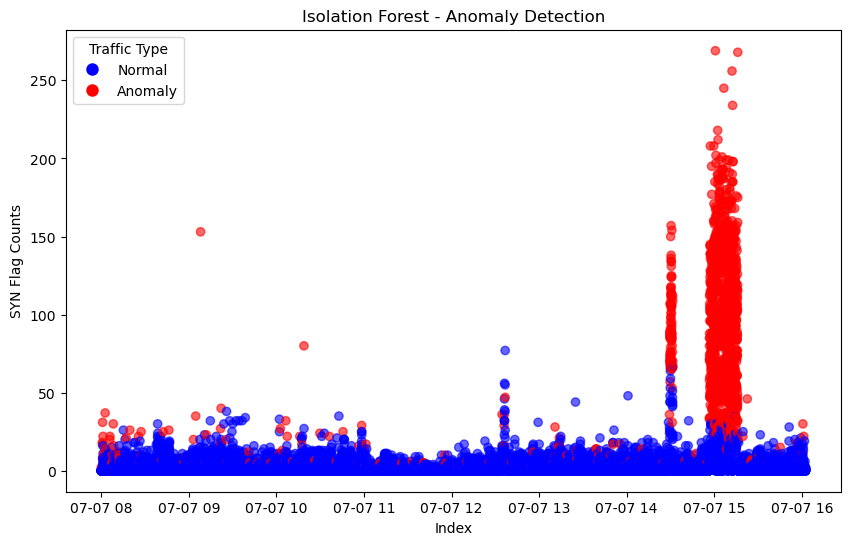

In [267]:
from sklearn.ensemble import IsolationForest
import matplotlib.colors as mcolors

X = friday_data_agg[features]
y = friday_data_agg['label']

model = IsolationForest(contamination=0.04, random_state=42)

anomaly_score = model.fit_predict(X)

X[anomaly_score == -1].index


# Define colors manually
colors = np.where(anomaly_score == -1, 'red', 'blue')  # Red for anomalies, blue for normal

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X.index, X['requests_rate'], c=colors, alpha=0.6)

# Manually create legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label="Normal"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label="Anomaly")
]

plt.xlabel("Index")
plt.ylabel("SYN Flag Counts")
plt.title("Isolation Forest - Anomaly Detection")
plt.legend(handles=handles, title="Traffic Type")

# Show the plot
plt.show()

In [268]:
y_true = np.where(y == 0, 1, -1)
print("\nClassification Report:\n", classification_report(y_true, anomaly_score, target_names=["Normal", "Anomaly"]))


Classification Report:
               precision    recall  f1-score   support

      Normal       0.80      0.86      0.83      1083
     Anomaly       0.99      0.99      0.99     27889

    accuracy                           0.99     28972
   macro avg       0.90      0.92      0.91     28972
weighted avg       0.99      0.99      0.99     28972



In [272]:
from sklearn.metrics import precision_recall_fscore_support

best_f1, best_contamination = 0, None
for c in np.arange(0.01, 0.2, 0.01):
    model = IsolationForest(contamination=c, random_state=42)
    anomaly_score = model.fit_predict(X)

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, anomaly_score, average='binary', pos_label=-1)

    print(f"contamination: {c}. f1: {f1}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_contamination = c

print(f"Best contamination: {best_contamination} with F1-score: {best_f1:.4f}")

contamination: 0.01. f1: 0.4224326292789512
contamination: 0.02. f1: 0.6794948887552615
contamination: 0.03. f1: 0.8202764976958525
contamination: 0.04. f1: 0.8267857142857142
contamination: 0.05. f1: 0.8025276461295419
contamination: 0.06. f1: 0.7313961729270021
contamination: 0.07. f1: 0.6679524268723883
contamination: 0.08. f1: 0.6186415760070567
contamination: 0.09. f1: 0.5738282308317529
contamination: 0.1. f1: 0.5356872635561161
contamination: 0.11. f1: 0.5007025761124122
contamination: 0.12. f1: 0.4706140350877193
contamination: 0.13. f1: 0.44265676567656764
contamination: 0.14. f1: 0.41875851332944153
contamination: 0.15. f1: 0.3978633265794806
contamination: 0.16. f1: 0.3783878300402168
contamination: 0.17. f1: 0.36051930758988016
contamination: 0.18. f1: 0.34397332062887087
contamination: 0.19. f1: 0.32877959927140255
Best contamination: 0.04 with F1-score: 0.8268


Ok, it's clear where's the DDOS attack. Aggregation and isolation forest combination should be good enough to track it down. However, it depends on the contamination parameter and might produce a lot of false positives.

Let's implement CUSUM

In [109]:
import torch
import numpy as np
from typing import Tuple


class CusumMeanDetector():
        
    def __init__(self, t_warmup = 30, p_limit = 0.01) -> None:
        self._t_warmup = t_warmup
        self._p_limit = p_limit
        
        self._reset()
        
        

    def predict_next(self, y: torch.tensor) -> Tuple[float,bool]:
        self._update_data(y)

        if self.current_t == self._t_warmup:
            self._init_params()
        
        if self.current_t >= self._t_warmup:
            prob, is_changepoint = self._check_for_changepoint()
            if is_changepoint:
                self._reset()

            return (1-prob), is_changepoint
        
        else:
            return 0, False
            
    
    def _reset(self) -> None:
        self.current_t = torch.zeros(1)
                
        self.current_obs = []
        
        self.current_mean = None
        self.current_std = None
            
    
    def _update_data(self, y: torch.tensor) -> None:
        self.current_t += 1
        self.current_obs.append(y.reshape(1))

        
    
    def _init_params(self) -> None:
        self.current_mean = torch.mean(torch.concat(self.current_obs))
        self.current_std = torch.std(torch.concat(self.current_obs))
             
    
    def _check_for_changepoint(self) -> Tuple[float,bool]:
        eps = 1e-8
        standardized_sum = torch.sum(torch.concat(self.current_obs) - self.current_mean) / (self.current_std + eps) * self.current_t**0.5
        prob = self._get_prob(standardized_sum).detach().numpy().item()
        
        return prob, prob < self._p_limit
    
    
    def _get_prob(self, y: torch.tensor) -> bool:
        p = torch.distributions.normal.Normal(0,1).cdf(torch.abs(y))
        prob = 2*(1 - p)
        
        return prob

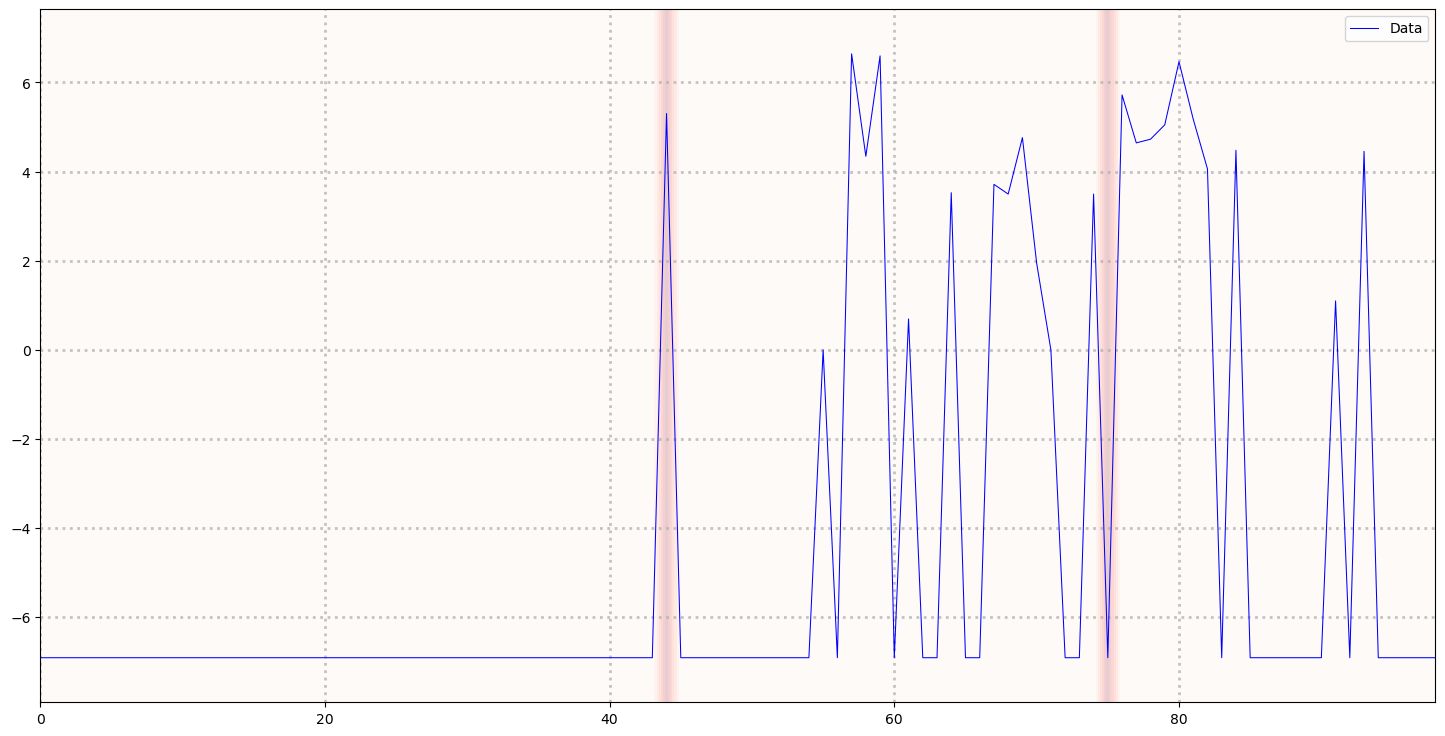

In [116]:
import matplotlib.pyplot as plt

np.random.seed(456)
torch.manual_seed(456)

test_log = np.log(friday_data_agg['ack_flag_counts'].values[1:100] + 0.001)

y = torch.tensor(test_log, dtype=torch.float32)

# Apply the detector
test = CusumMeanDetector()
outs = [test.predict_next(y[i]) for i in range(len(y))]

# Extract changepoints
cps = np.array([]); np.where(list(map(lambda x: x[1], outs)))[0]
probs = np.array(list(map(lambda x: x[0], outs)))


# Create mesh grid for visualization
X, Y = np.meshgrid(np.arange(len(y)), np.linspace(y.min()-1, y.max()+1))
Z = probs[X]

# Plot results
plt.figure(figsize=(18,9))
plt.contourf(X, Y, Z, alpha=0.2, cmap="Reds")
plt.plot(np.arange(len(y)), y.numpy(), lw=0.75, label="Data", color="blue")

# Detected changepoints
if len(cps) > 0:
    plt.axvline(cps[0], color="red", linestyle="dashed", label="Detected changepoints", lw=2)
    [plt.axvline(cp, color="red", linestyle="dashed", lw=2) for cp in cps[1:]]

plt.grid(alpha=0.75, linestyle="dotted", lw=2)
plt.legend()
plt.show()

As we can see from above plot, entropy based CUSUM doesn't really work for network use case, because there's no stable distribution of data. Treshold based CUSUM requires a constant treshold value which isn't stable for network traffic.